Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
import scipy.stats as stats
%matplotlib inline 
sns.set(style="ticks")

Загрузка датасета

In [2]:
hdata_loaded  = pd.read_csv("googleplaystore.csv")
print(hdata_loaded)

       Unnamed: 0                                                App  \
0               0     Photo Editor & Candy Camera & Grid & ScrapBook   
1               1                                Coloring book moana   
2               2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3               3                              Sketch - Draw & Paint   
4               4              Pixel Draw - Number Art Coloring Book   
...           ...                                                ...   
10836       10836                                   Sya9a Maroc - FR   
10837       10837                   Fr. Mike Schmitz Audio Teachings   
10838       10838                             Parkinson Exercices FR   
10839       10839                      The SCP Foundation DB fr nn5n   
10840       10840      iHoroscope - 2018 Daily Horoscope & Astrology   

                  Category  Rating Reviews                Size     Installs  \
0           ART_AND_DESIGN     4.1     159              

Устранение пропусков в данных

In [3]:
hdata = hdata_loaded
list(zip(hdata.columns, [i for i in hdata.dtypes]))

[('Unnamed: 0', dtype('int64')),
 ('App', dtype('O')),
 ('Category', dtype('O')),
 ('Rating', dtype('float64')),
 ('Reviews', dtype('O')),
 ('Size', dtype('O')),
 ('Installs', dtype('O')),
 ('Type', dtype('O')),
 ('Price', dtype('O')),
 ('Content Rating', dtype('O')),
 ('Genres', dtype('O')),
 ('Last Updated', dtype('O')),
 ('Current Ver', dtype('O')),
 ('Android Ver', dtype('O'))]

In [4]:
# Колонки с пропусками
hcols_with_na = [c for c in hdata.columns if hdata[c].isnull().sum() > 0]
hcols_with_na

['Rating', 'Type', 'Content Rating', 'Current Ver', 'Android Ver']

In [5]:
# Количество пропусков
[(c, hdata[c].isnull().sum()) for c in hcols_with_na]

[('Rating', 1474),
 ('Type', 1),
 ('Content Rating', 1),
 ('Current Ver', 8),
 ('Android Ver', 3)]

In [6]:
# Доля (процент) пропусков
[(c, hdata[c].isnull().mean()) for c in hcols_with_na]

[('Rating', 0.13596531685268887),
 ('Type', 9.224241306152569e-05),
 ('Content Rating', 9.224241306152569e-05),
 ('Current Ver', 0.0007379393044922055),
 ('Android Ver', 0.0002767272391845771)]

Заполнение показателями центра распределения и константой

In [7]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

In [8]:
all_data, filled_data, missed_data = impute_column(hdata, 'Rating', 'mean')
all_data

array([4.1       , 3.9       , 4.7       , ..., 4.19333832, 4.5       ,
       4.5       ])

In [9]:
filled_data

array([4.19333832, 4.19333832, 4.19333832, ..., 4.19333832, 4.19333832,
       4.19333832])

In [10]:
missed_data

array([nan, nan, nan, ..., nan, nan, nan])

In [11]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))
    
    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))
    
    new_df = pd.DataFrame({'Исходные данные':original_data})
       
    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data
        
    sns.kdeplot(data=new_df)

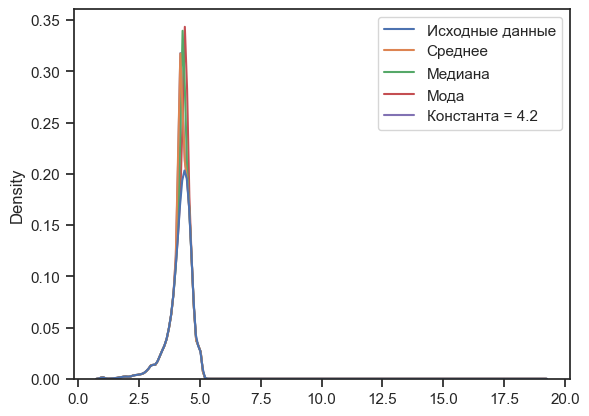

In [12]:
research_impute_numeric_column(hdata, 'Rating', 4.2)

In [13]:
knnimpute_cols = ['Unnamed: 0','Rating']
knnimpute_hdata = hdata[knnimpute_cols].copy()
knnimputer = KNNImputer(
    n_neighbors=5, 
    weights='distance', 
    metric='nan_euclidean', 
    add_indicator=False, 
)
knnimpute_hdata_imputed_temp = knnimputer.fit_transform(knnimpute_hdata)
knnimpute_hdata_imputed = pd.DataFrame(knnimpute_hdata_imputed_temp, columns=knnimpute_hdata.columns)
knnimpute_hdata_imputed.head()

,Unnamed: 0,Rating
0,0.0,4.1
1,1.0,3.9
2,2.0,4.7
3,3.0,4.5
4,4.0,4.3


In [14]:
# Пропуски заполнены
knnimpute_hdata_imputed.isnull().sum()

Unnamed: 0    0
Rating        0
dtype: int64

In [15]:
LotFrontage_df = pd.DataFrame({'original': knnimpute_hdata['Rating'].values})
LotFrontage_df['KNN_5'] = knnimpute_hdata_imputed['Rating']

In [16]:
hdata_loaded['Rating'] = LotFrontage_df['KNN_5']
hcols_with_na = [c for c in hdata_loaded.columns if hdata_loaded[c].isnull().sum() > 0]
[(c, hdata_loaded[c].isnull().sum()) for c in hcols_with_na]

[('Type', 1), ('Content Rating', 1), ('Current Ver', 8), ('Android Ver', 3)]

In [17]:
hdata_loaded

,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.100000,159,19M,"10,000+",Free,0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.900000,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.700000,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.500000,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.300000,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,10836,Sya9a Maroc - FR,FAMILY,4.500000,38,53M,"5,000+",Free,0,Everyone,Education,25-Jul-17,1.48,4.1 and up
10837,10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.000000,4,3.6M,100+,Free,0,Everyone,Education,6-Jul-18,1,4.1 and up
10838,10838,Parkinson Exercices FR,MEDICAL,4.615385,3,9.5M,"1,000+",Free,0,Everyone,Medical,20-Jan-17,1,2.2 and up
10839,10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.500000,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,19-Jan-15,Varies with device,Varies with device


In [18]:
hcols_with_na = [c for c in hdata_loaded.columns if hdata_loaded[c].isnull().sum() > 0]
[(c, hdata_loaded[c].isnull().sum()) for c in hcols_with_na]

[('Type', 1), ('Content Rating', 1), ('Current Ver', 8), ('Android Ver', 3)]

In [19]:
res = hdata_loaded.dropna(axis=0, how='any')

In [20]:
hcols_with_na = [c for c in res.columns if res[c].isnull().sum() > 0]
[(c, res[c].isnull().sum()) for c in hcols_with_na]

[]

In [21]:
Categlist = res['Category'].unique().tolist()
for i in res['Category']:
    for j in Categlist:
        if i == j:
            k = res[res['Category']==i].index[0]
            res['Category'][k] = Categlist.index(j)

c:\users\aleka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
Typelist = res['Type'].unique().tolist()
for i in res['Type']:
    for j in Typelist:
        if i == j:
            k = res[res['Type']==i].index[0]
            res['Type'][k] = Typelist.index(j)

c:\users\aleka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
ContentRatinglist = res['Content Rating'].unique().tolist()
for i in res['Content Rating']:
    for j in ContentRatinglist:
        if i == j:
            k = res[res['Content Rating']==i].index[0]
            res['Content Rating'][k] = ContentRatinglist.index(j)

c:\users\aleka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Кодирование категориального признака Category с использованием метода "count (frequency) encoding"

In [24]:
res = res.drop('Unnamed: 0', axis = 1)
res

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,0,4.100000,159,19M,"10,000+",0,0,0,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,Coloring book moana,0,3.900000,967,14M,"500,000+",0,0,0,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",0,4.700000,87510,8.7M,"5,000,000+",0,0,0,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,0,4.500000,215644,25M,"50,000,000+",0,0,1,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,0,4.300000,967,2.8M,"100,000+",0,0,0,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,18,4.500000,38,53M,"5,000+",0,0,0,Education,25-Jul-17,1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,18,5.000000,4,3.6M,100+,0,0,0,Education,6-Jul-18,1,4.1 and up
10838,Parkinson Exercices FR,19,4.615385,3,9.5M,"1,000+",0,0,0,Medical,20-Jan-17,1,2.2 and up
10839,The SCP Foundation DB fr nn5n,3,4.500000,114,Varies with device,"1,000+",0,0,3,Books & Reference,19-Jan-15,Varies with device,Varies with device


In [25]:
from category_encoders.count import CountEncoder as ce_CountEncoder

In [26]:
ce_CountEncoder1 = ce_CountEncoder()
data_COUNT_ENC = ce_CountEncoder1.fit_transform(res[res.columns.difference(['Survived'])])

In [27]:
data_COUNT_ENC

,Android Ver,App,Category,Content Rating,Current Ver,Genres,Installs,Last Updated,Price,Rating,Reviews,Size,Type
0,1501,1,64,8704,136,57,1052,6,10032,4.100000,9,154,10032
1,1501,2,64,8704,51,2,538,10,10032,3.900000,4,193,10032
2,1501,1,64,8704,10,57,752,285,10032,4.700000,1,38,10032
3,393,1,64,1208,1458,57,289,38,10032,4.500000,1,143,10032
4,980,1,64,8704,275,7,1169,44,10032,4.300000,4,65,10032
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,2451,1,1968,8704,3,548,476,6,10032,4.500000,29,43,10032
10837,2451,1,1968,8704,842,548,718,63,10032,5.000000,137,57,10032
10838,244,1,463,8704,842,463,905,2,10032,4.615385,175,28,10032
10839,1361,1,230,499,1458,230,905,2,10032,4.500000,13,1694,10032


In [28]:
res['Category'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=object)

In [29]:
data_COUNT_ENC['Category'].unique()

array([  64,   85,   53,  230,  460,   60,  387,  234,  156,  149,  366,
        127,  341,   88,   84,  382, 1144, 1968,  463,  295,  260,  335,
        384,  258,  841,  390,  424,   82,  175,  283,  137], dtype=int64)

In [30]:
ce_CountEncoder2 = ce_CountEncoder(normalize=True)
data_FREQ_ENC = ce_CountEncoder2.fit_transform(res[res.columns.difference(['Survived'])])

In [31]:
data_FREQ_ENC

,Android Ver,App,Category,Content Rating,Current Ver,Genres,Installs,Last Updated,Price,Rating,Reviews,Size,Type
0,0.138609,0.000092,0.005910,0.803768,0.012559,0.005264,0.097147,0.000554,0.926401,4.100000,0.000831,0.014221,0.926401
1,0.138609,0.000185,0.005910,0.803768,0.004710,0.000185,0.049681,0.000923,0.926401,3.900000,0.000369,0.017823,0.926401
2,0.138609,0.000092,0.005910,0.803768,0.000923,0.005264,0.069443,0.026318,0.926401,4.700000,0.000092,0.003509,0.926401
3,0.036291,0.000092,0.005910,0.111552,0.134638,0.005264,0.026688,0.003509,0.926401,4.500000,0.000092,0.013205,0.926401
4,0.090498,0.000092,0.005910,0.803768,0.025395,0.000646,0.107951,0.004063,0.926401,4.300000,0.000369,0.006002,0.926401
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,0.226337,0.000092,0.181734,0.803768,0.000277,0.050605,0.043956,0.000554,0.926401,4.500000,0.002678,0.003971,0.926401
10837,0.226337,0.000092,0.181734,0.803768,0.077754,0.050605,0.066303,0.005818,0.926401,5.000000,0.012651,0.005264,0.926401
10838,0.022532,0.000092,0.042756,0.803768,0.077754,0.042756,0.083572,0.000185,0.926401,4.615385,0.016160,0.002586,0.926401
10839,0.125681,0.000092,0.021239,0.046080,0.134638,0.021239,0.083572,0.000185,0.926401,4.500000,0.001200,0.156432,0.926401


In [32]:
data_FREQ_ENC['Category'].unique()

array([0.00591006, 0.00784929, 0.00489427, 0.02123926, 0.04247853,
       0.00554068, 0.03573737, 0.02160864, 0.01440576, 0.01375935,
       0.03379813, 0.01172777, 0.03148952, 0.00812633, 0.00775695,
       0.03527565, 0.10564226, 0.18173423, 0.04275556, 0.02724167,
       0.0240096 , 0.03093545, 0.03546034, 0.02382491, 0.07766183,
       0.03601441, 0.03915412, 0.00757226, 0.01616031, 0.02613353,
       0.01265121])

Масштабирование данных для числового признака quality с использованием масштабирования по медиане

In [33]:
df = pd.read_csv("winequalityN.csv")
Typelist = df['type'].unique().tolist()
for i in df['type']:
    for j in Typelist:
        if i == j:
            k = df[df['type']==i].index[0]
            df['type'][k] = Typelist.index(j)
df

c:\users\aleka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,0,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,0,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,0,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,0,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,1,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,1,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,1,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,1,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [34]:
X_ALL = df.drop('quality', axis=1)
# Функция для восстановления датафрейма
# на основе масштабированных данных
def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=X_ALL.columns)
    return res
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_ALL, df['quality'],
                                                    test_size=0.2,
                                                    random_state=1)
# Преобразуем массивы в DataFrame
X_train_df = arr_to_df(X_train)
X_test_df = arr_to_df(X_test)

X_train_df.shape, X_test_df.shape

((5197, 12), (1300, 12))

In [35]:
from sklearn.preprocessing import RobustScaler
cs41 = RobustScaler()
data_cs41_scaled_temp = cs41.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs41_scaled = arr_to_df(data_cs41_scaled_temp)
data_cs41_scaled.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,6497.000000,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000
mean,0.246114,0.166599,0.292300,0.062299,0.387988,0.334873,0.063555,-0.028550,-0.041584,0.039979,0.124795,0.106556
std,0.430779,0.997500,0.968524,1.037606,0.755258,1.297631,0.739558,0.715467,0.644876,0.765468,0.875377,0.662618
min,0.000000,-2.461538,-1.235294,-2.214286,-0.380952,-1.407407,-1.166667,-1.417722,-1.673118,-2.333333,-1.705882,-1.277778
25%,0.000000,-0.461538,-0.352941,-0.428571,-0.190476,-0.333333,-0.500000,-0.518987,-0.548387,-0.476190,-0.470588,-0.444444
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.538462,0.647059,0.571429,0.809524,0.666667,0.500000,0.481013,0.451613,0.523810,0.529412,0.555556
max,1.000000,6.846154,7.588235,9.642857,9.968254,20.888889,10.833333,4.075949,9.481720,3.809524,8.764706,2.555556


In [36]:
cs42 = RobustScaler()
cs42.fit(X_train)
data_cs42_scaled_train_temp = cs42.transform(X_train)
data_cs42_scaled_test_temp = cs42.transform(X_test)
# формируем DataFrame на основе массива
data_cs42_scaled_train = arr_to_df(data_cs42_scaled_train_temp)
data_cs42_scaled_test = arr_to_df(data_cs42_scaled_test_temp)

In [37]:
# Построение плотности распределения
def draw_kde(col_list, df1, df2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(12, 5))
    # первый график
    ax1.set_title(label1)
    sns.kdeplot(data=df1[col_list], ax=ax1)
    # второй график
    ax2.set_title(label2)
    sns.kdeplot(data=df2[col_list], ax=ax2)
    plt.show()

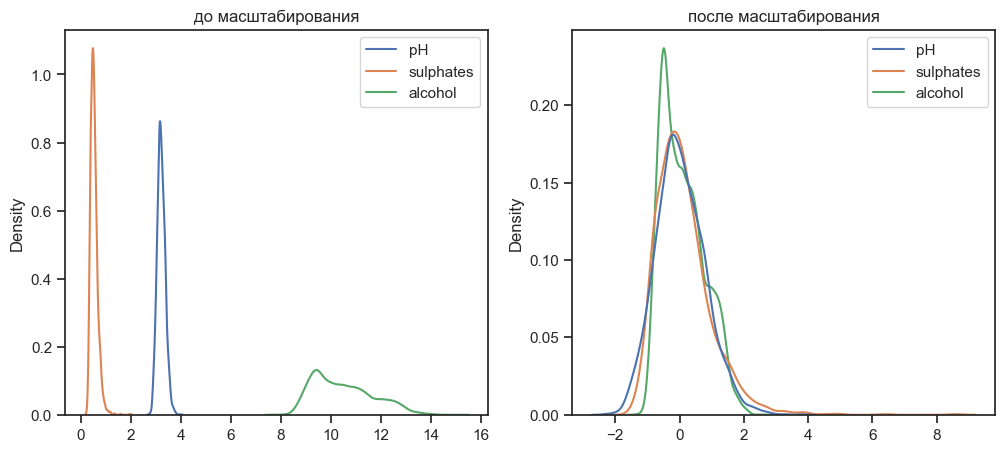

In [38]:
x_col_list = ['pH','sulphates','alcohol']
draw_kde(x_col_list, df, data_cs41_scaled, 'до масштабирования', 'после масштабирования')

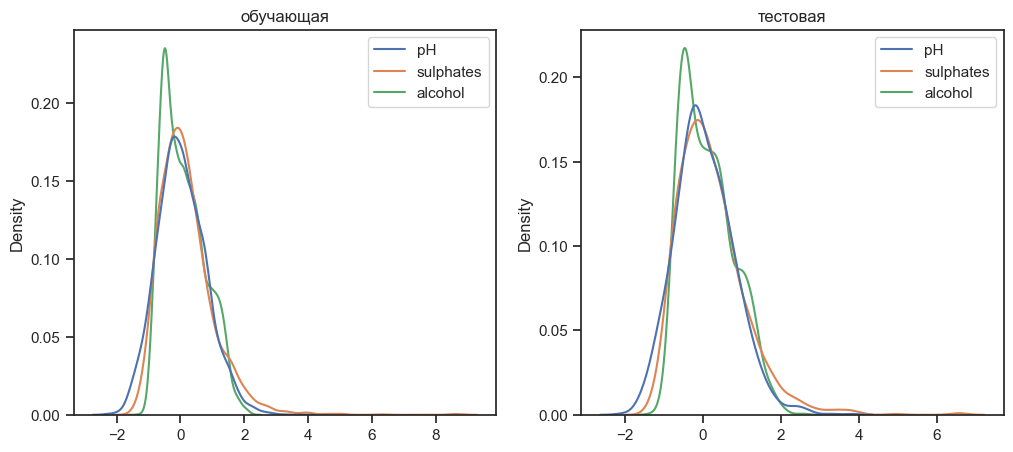

In [39]:
draw_kde(x_col_list, data_cs42_scaled_train, data_cs42_scaled_test, 'обучающая', 'тестовая')

Парные диаграммы (pairplot)

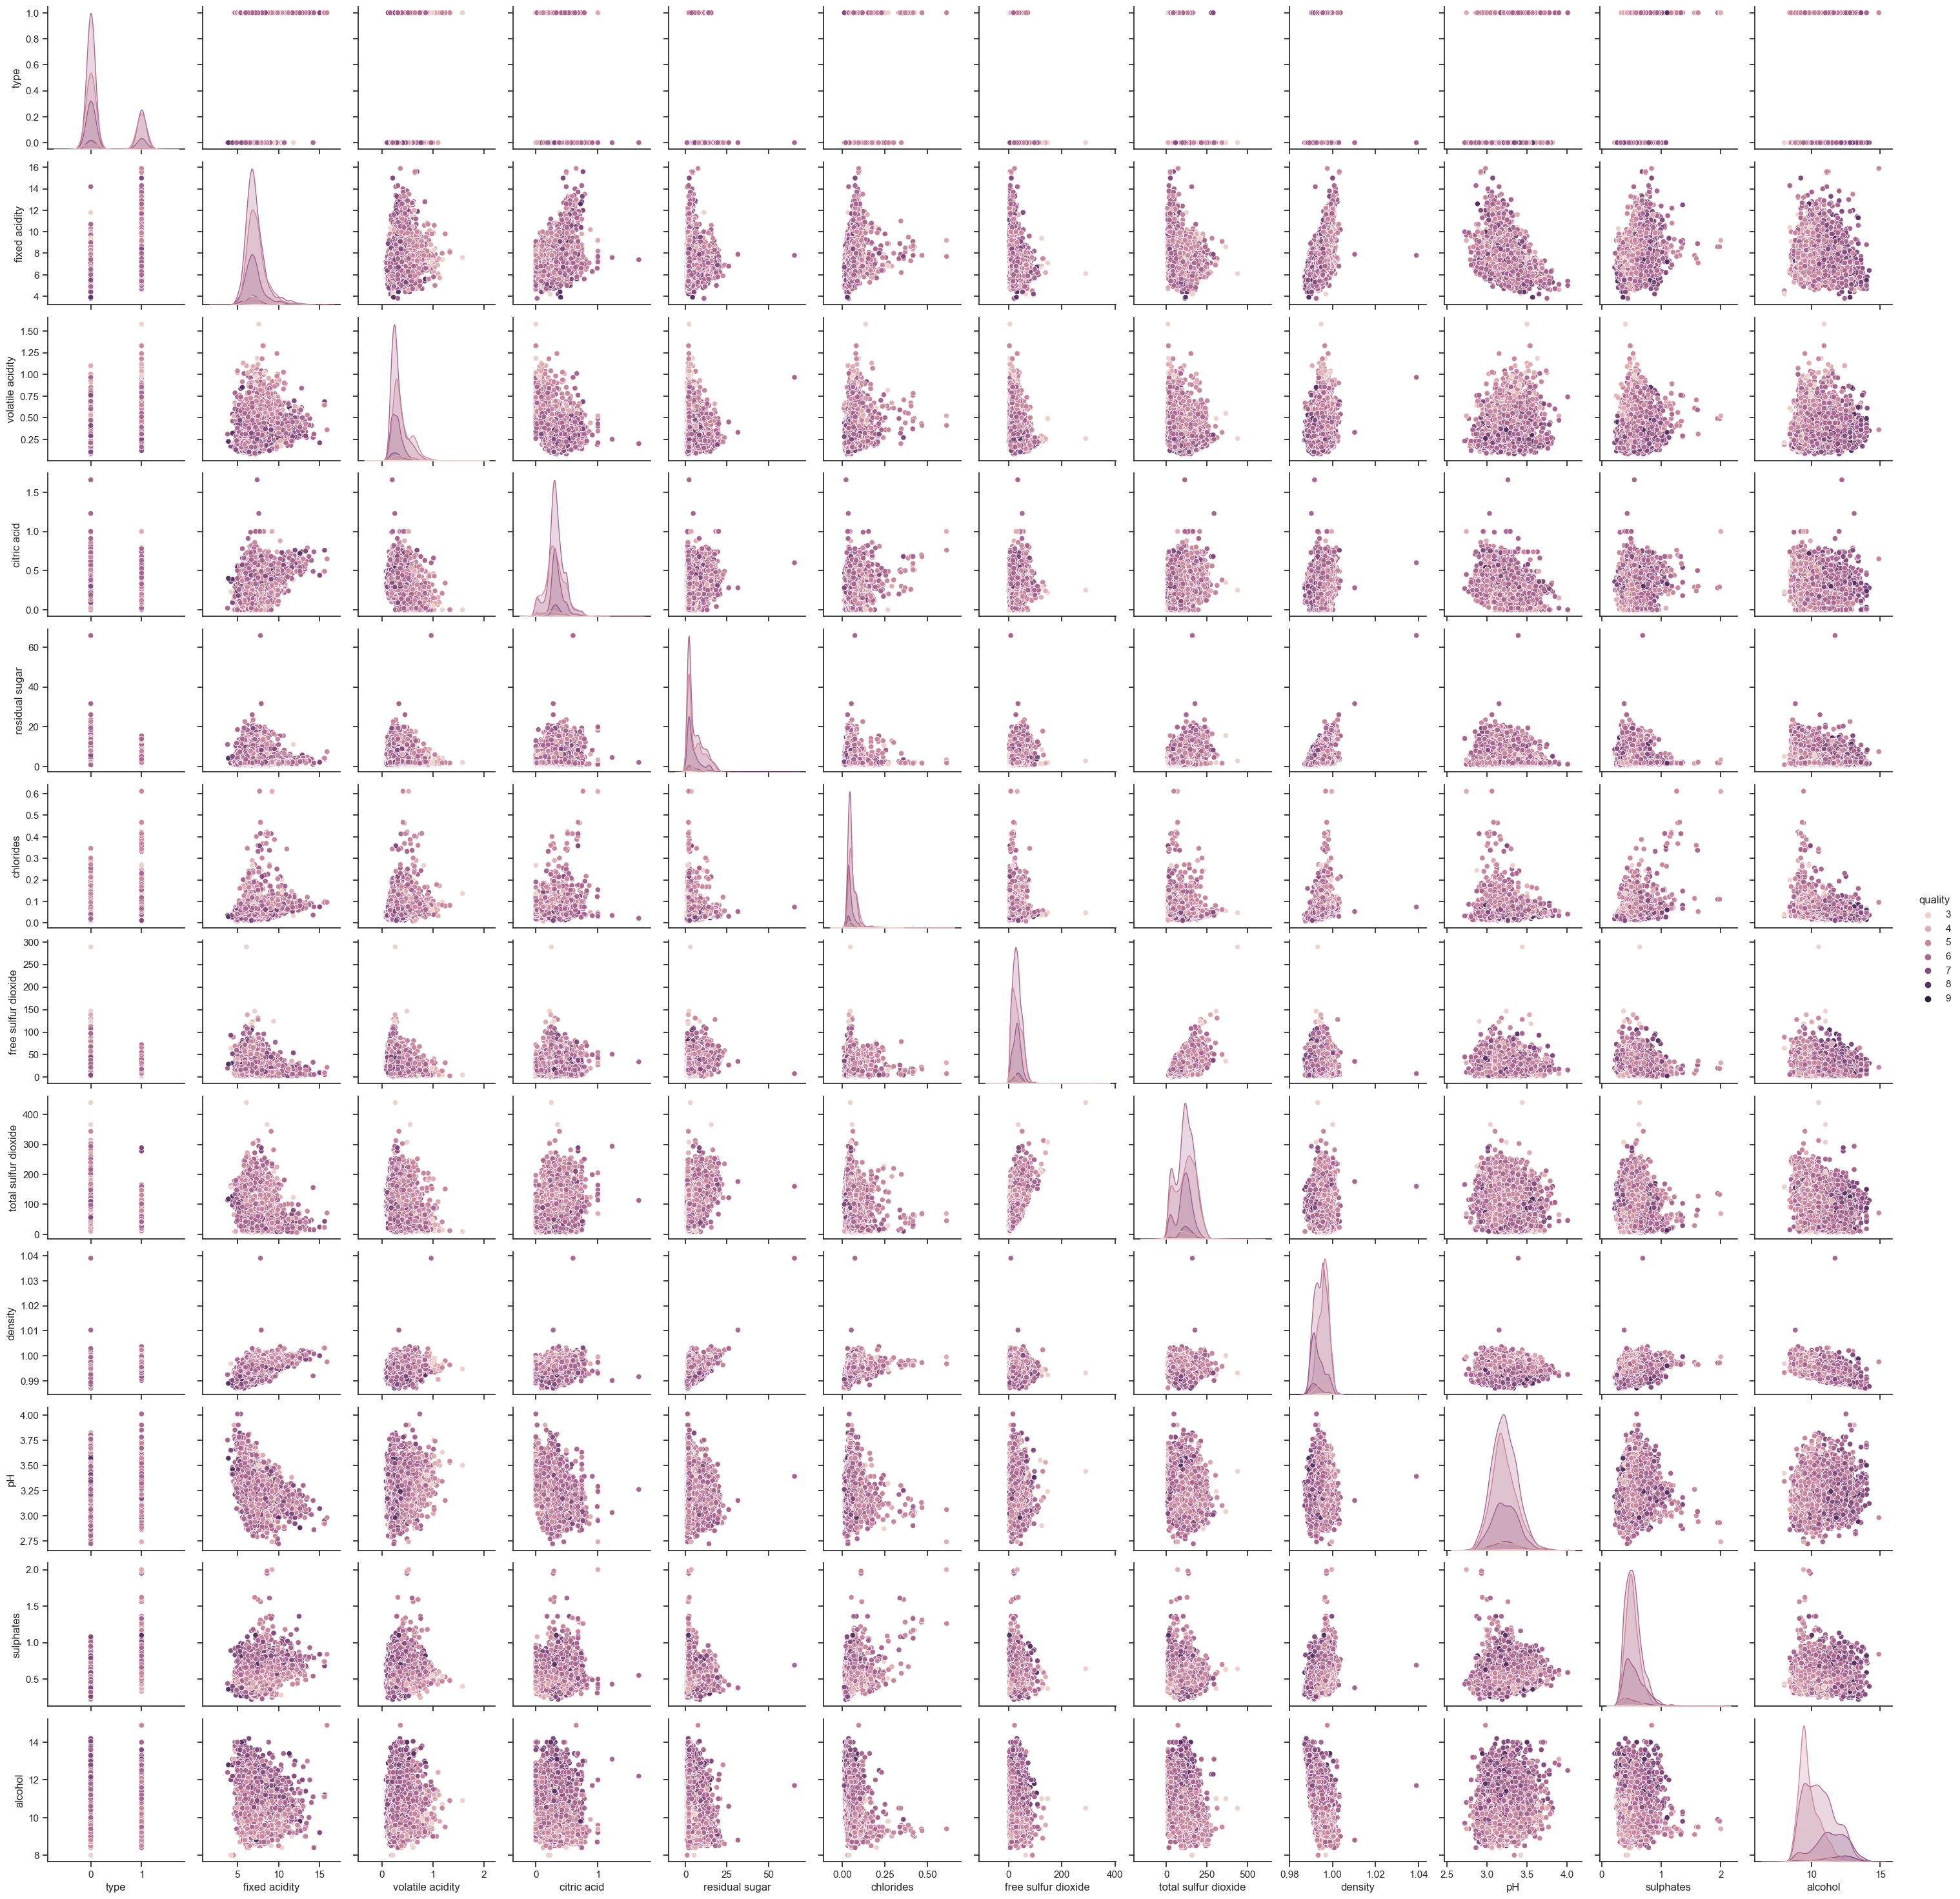

In [40]:
# pairplot with hue quality
sns.pairplot(df, hue ='quality')
# to show
plt.show()